The purpose of this exercise is to show how decision rules can be extracted from a decision tree and also the decision rules used to classify some training data.

# Python packages

In [1]:
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier,  export_text
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np

# Train

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
y_train = [str(i) for i in y_train]
# Train
clf = DecisionTreeClassifier(criterion='gini',max_depth=30, random_state=123).fit(X_train, y_train)
clf

DecisionTreeClassifier(max_depth=30, random_state=123)

# Decision Tree plot

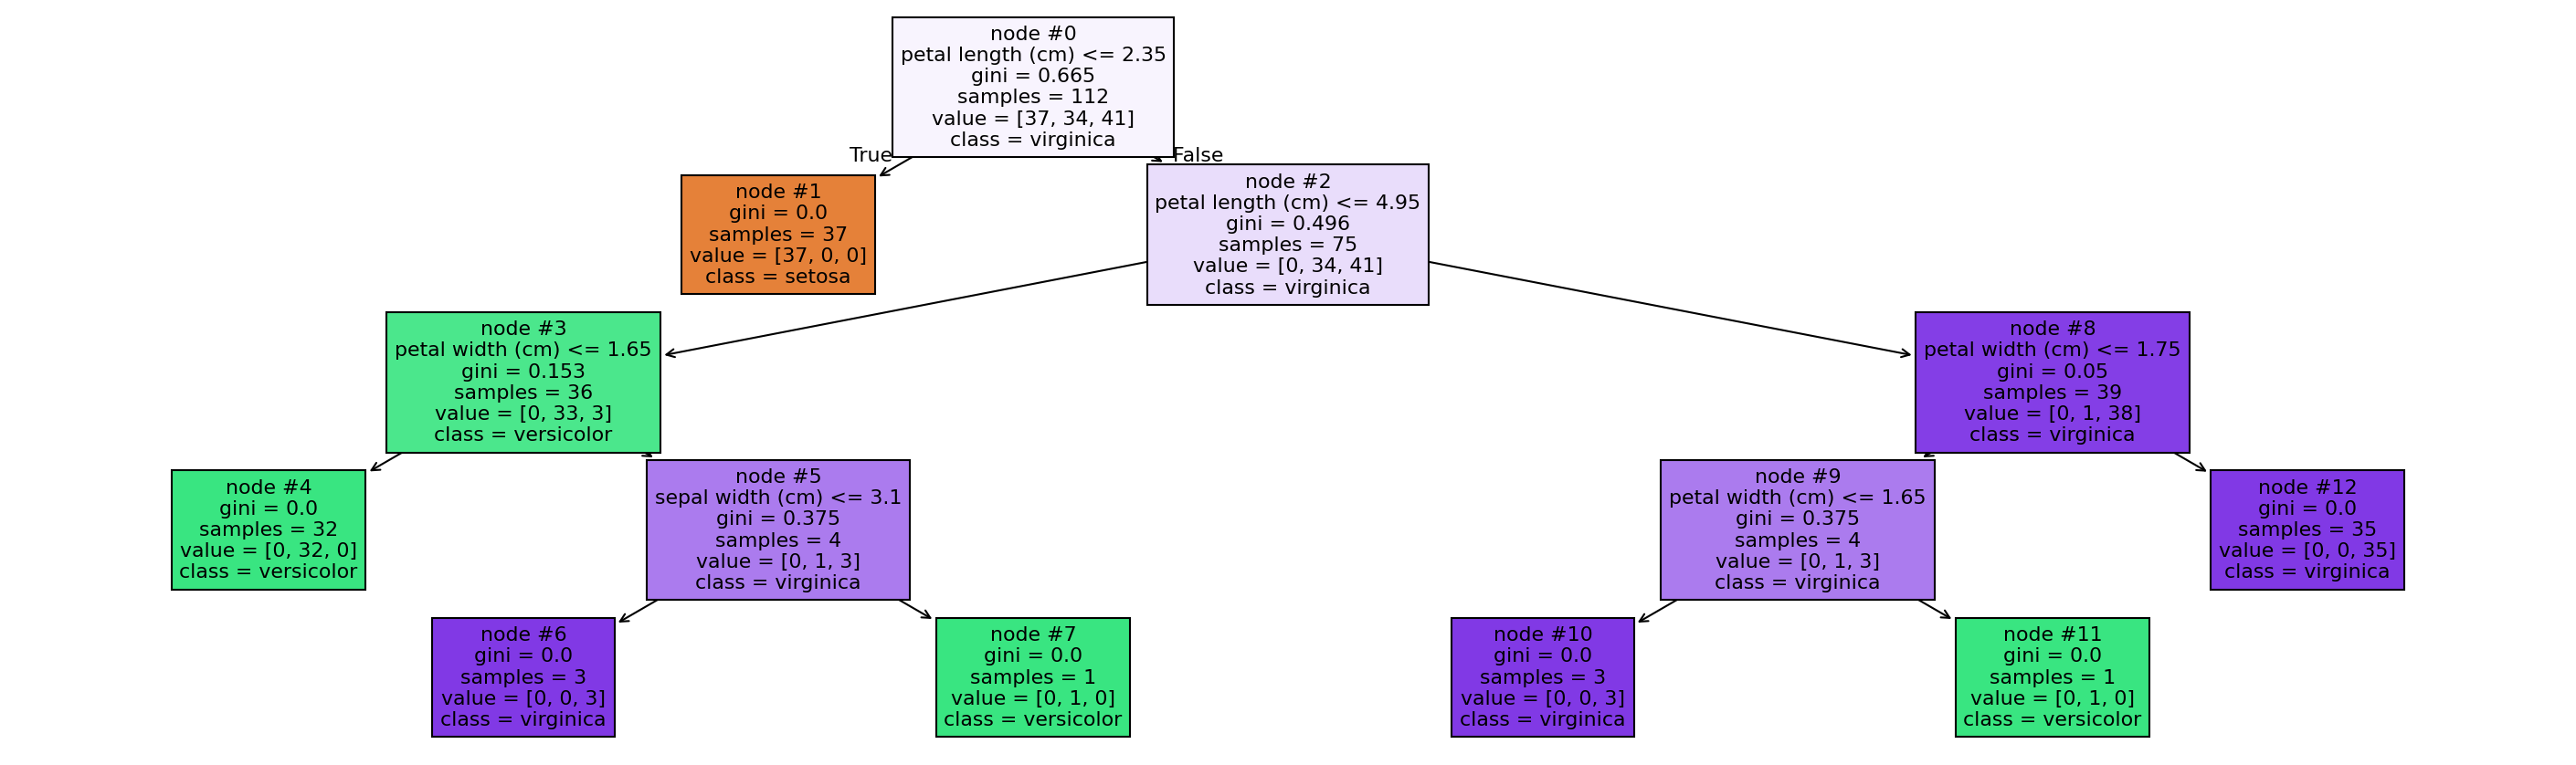

In [13]:
plt.figure(figsize=(24,7), dpi=150)
tree.plot_tree(
    decision_tree = clf,
    feature_names = iris.feature_names,
    class_names   = iris.target_names,
    node_ids      = True,
    filled        = True
)
plt.show()

# Decisions applied to classify the sample n

In [15]:
# Sample from X_test
sample_id = 10

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)
flower_variety = iris.target_names[int(clf.predict([X_test[sample_id]])[0])]

# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print(f"Flower Variety classified as [{flower_variety}], rules used to predict sample [{sample_id}]")
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "Decision node {node} : ({feature} = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=iris.feature_names[feature[node_id]],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Flower Variety classified as [virginica], rules used to predict sample [10]
Decision node 0 : (petal length (cm) = 5.6) > 2.350000023841858)
Decision node 2 : (petal length (cm) = 5.6) > 4.950000047683716)
Decision node 8 : (petal width (cm) = 1.4) <= 1.75)
Decision node 9 : (petal width (cm) = 1.4) <= 1.6500000357627869)


# Consolidated decision rules for classifying each flower variety

In [5]:
feature_names = iris.feature_names
class_names = iris.target_names

# Función para recorrer el árbol y extraer reglas
def extract_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != -2:  # Si no es un nodo hoja
            name = feature_names[feature[node]]
            threshold_value = threshold[node]
            # Regla para el lado izquierdo
            left_condition = conditions + [f"({name} <= {threshold_value:.2f})"]
            recurse(tree_.children_left[node], left_condition)
            # Regla para el lado derecho
            right_condition = conditions + [f"({name} > {threshold_value:.2f})"]
            recurse(tree_.children_right[node], right_condition)
        else:  # Si es un nodo hoja
            class_label = np.argmax(tree_.value[node])
            rules.append((conditions, class_names[class_label]))

    recurse(0, [])
    return rules

# Extraer las reglas
rules = extract_rules(clf, feature_names, class_names)

# Organizar las reglas por clase
rules_per_class = {class_name: [] for class_name in class_names}
for conditions, class_name in rules:
    rules_per_class[class_name].append(" AND ".join(conditions))

# Imprimir las reglas por clase
for class_name, class_rules in rules_per_class.items():
    print(f"Decision rules for the class '{class_name}':")
    for rule in class_rules:
        print(f"  {rule}")
    print()


Decision rules for the class 'setosa':
  (petal length (cm) <= 2.35)

Decision rules for the class 'versicolor':
  (petal length (cm) > 2.35) AND (petal length (cm) <= 4.95) AND (petal width (cm) <= 1.65)
  (petal length (cm) > 2.35) AND (petal length (cm) <= 4.95) AND (petal width (cm) > 1.65) AND (sepal width (cm) > 3.10)
  (petal length (cm) > 2.35) AND (petal length (cm) > 4.95) AND (petal width (cm) <= 1.75) AND (petal width (cm) > 1.65)

Decision rules for the class 'virginica':
  (petal length (cm) > 2.35) AND (petal length (cm) <= 4.95) AND (petal width (cm) > 1.65) AND (sepal width (cm) <= 3.10)
  (petal length (cm) > 2.35) AND (petal length (cm) > 4.95) AND (petal width (cm) <= 1.75) AND (petal width (cm) <= 1.65)
  (petal length (cm) > 2.35) AND (petal length (cm) > 4.95) AND (petal width (cm) > 1.75)

